In [1]:
%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import pickle
from metric import *
from utils import * 

In [2]:
dataroot = '/data/voc2012'
SAVE_DIR = '/data/model'
model_name = 'deeplabv3_30_semisup_voc.pt'
save = os.path.join(SAVE_DIR,model_name)
batch_size = 2

## Datasets and dataloader

In [3]:
def to_tensor_target(img):
  img = np.array(img)
  # border
  img[img==255] = 0 # border = background 
  return torch.LongTensor(img)


size = (513,513)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
transform_input = transforms.Compose([
                                   transforms.Resize(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                    ])

transform_mask = transforms.Compose([
                                   transforms.Resize(size),
                                   transforms.Lambda(to_tensor_target)
                                   ])

In [4]:
train_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='train', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

val_dataset = dset.VOCSegmentation(dataroot,year='2012', image_set='val', download=True,
                                     transform= transform_input,
                                     target_transform= transform_mask)

Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /data/voc2012/VOCtrainval_11-May-2012.tar


In [5]:
train_dataset_supervised = split_dataset(train_dataset,0.3)

In [6]:
dataloader_train_unsupervised = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
dataloader_train_supervised = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device :",device)

device : cuda:0


## Model

In [7]:
model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False)
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Train model

In [8]:
learning_rate = 0.02 # à voir
moment = 0.9
wd = 1e-4
n_epochs = 35
angle_max = 30
gamma = 0 # smoothing loss parameters
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=moment, weight_decay=wd)
lr_scheduler_supervised = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: (1 - x / (len(dataloader_train_supervised) * n_epochs)) ** 0.9)
lr_scheduler_unsupervised = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lambda x: (1 - x / (len(dataloader_train_unsupervised) * n_epochs)) ** 0.9)

criterion_supervised = nn.CrossEntropyLoss(ignore_index=21) # On ignore la classe border.
criterion_unsupervised = nn.KLDivLoss(reduction='mean')

In [9]:

iou_train = []
iou_test = []
combine_loss_train = []
combine_loss_test = []
loss_train_unsup = []
loss_train_sup = []
loss_test = []
pix_accuracy =  []
#
all_combine_loss_train = []
all_loss_train_sup = []
all_loss_train_unsup = []
all_loss_test = []
all_iou_train= []
all_iou_test = []
all_pix_accuracy =  []

In [ ]:
for ep in range(n_epochs):
    print("EPOCH",ep)
    for batch_sup,batch_unsup in zip(dataloader_train_supervised,dataloader_train_unsupervised):

          model.train()
          angle = np.random.randint(0,angle_max)
          x_unsup,_ = batch_unsup
          loss_equiv,acc = compute_transformations_batch(x_unsup,model,angle,reshape=False,\
                                                         criterion=criterion_unsupervised,device=device)
          loss_equiv = loss_equiv.to(device) # otherwise bug in combining the loss
          x,mask = batch_sup
          x = x.to(device)
          mask = mask.to(device)
          pred = model(x)["out"]
          loss_sup = criterion_supervised(pred,mask)
          loss = loss_sup + gamma*loss_equiv # combine loss 
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # append for plot
          all_pix_accuracy.append(acc) # accuracy between the original mask and the transform mask put back in place
          all_loss_train_unsup.append(loss_equiv.item())
          all_loss_train_sup.append(loss_sup.item())
          all_combine_loss_train.append(loss.item())
          
    lr_scheduler_supervised.step()
    #
    m_loss_combine = np.array(all_combine_loss_train).mean()
    m_acc = np.array(all_pix_accuracy).mean()
    combine_loss_train.append(m_loss_combine)
    pix_accuracy.append(m_acc)
    loss_train_sup.append(np.array(all_loss_train_sup).mean())
    loss_train_unsup.append(np.array(all_loss_train_unsup).mean())
    
    all_pix_accuracy = []
    all_loss_train_unsup = []
    all_loss_train_sup = []
    all_combine_loss_train = []
    print("EP:",ep," combine loss train:",m_loss_combine," pixel accuracy between masks ",m_acc)

    for i,(x,mask) in enumerate(dataloader_val):
          x = x.to(device)
          mask = mask.to(device)
          model.eval()
          with torch.no_grad():
            pred = model(x)
            pred = pred["out"]
          loss = criterion_supervised(pred,mask)
          all_loss_test.append(loss.item())
          all_iou_test.append(float(iou(pred.argmax(dim=1).detach(),mask.detach())))

    m_iou = np.array(all_iou_test).mean()
    m_loss = np.array(all_loss_test).mean()
    loss_test.append(m_loss)
    iou_test.append(m_iou)
    all_loss_test = []
    all_iou_test = []
    print("EP:",ep," loss test:",m_loss," iou test:",m_iou)

    
    torch.save(model,save)
    


EPOCH 0


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
/workspace/utils.py:134: RuntimeWarning: invalid value encountered in true_divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
/workspace/utils.py:136: RuntimeWarning: invalid value encountered in true_divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))


Text(0, 0.5, 'Mean IOU')

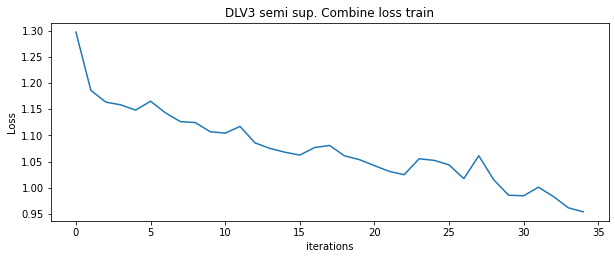

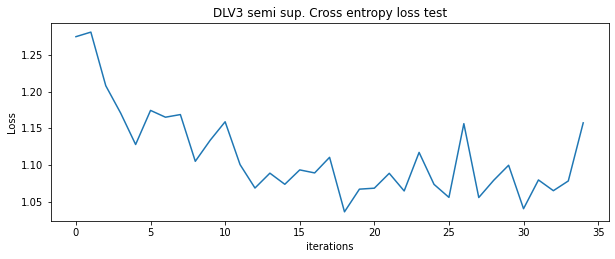

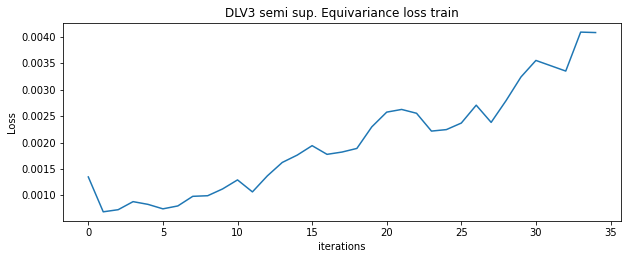

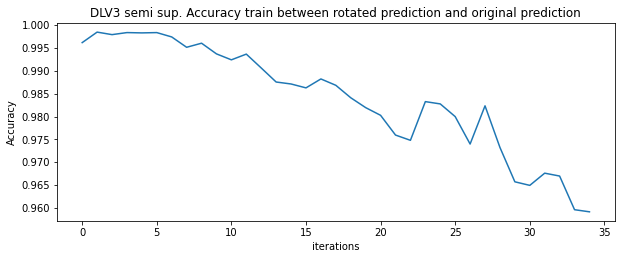

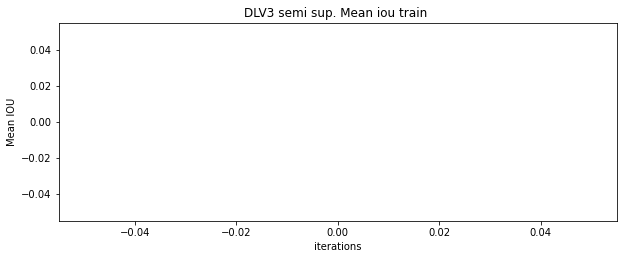

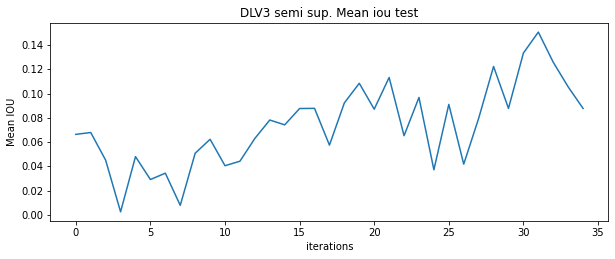

In [17]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Combine loss train")
plt.plot(combine_loss_train)
plt.xlabel("iterations")
plt.ylabel("Loss")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Cross entropy loss test")
plt.plot(loss_test)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Equivariance loss train")
plt.plot(loss_train_unsup)
plt.xlabel("iterations")
plt.ylabel("Loss")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Accuracy train between rotated prediction and original prediction")
plt.plot(pix_accuracy)
plt.xlabel("iterations")
plt.ylabel("Accuracy")

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Mean iou train ")
plt.plot(iou_train)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")


plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.title("DLV3 semi sup. Mean iou test")
plt.plot(iou_test)
plt.xlabel("iterations")
plt.ylabel("Mean IOU")